In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Lade Merkmal-Daten

In [17]:
from enum import Enum

class tableNames(Enum):
    features_sampleData= "features_sampleData"
    traces_top40k_2019 = "traces_top40k_2019"
    

In [18]:
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json 
client = bigquery.Client()
tableName = 'masterarbeit-245718.ethereum_us.{}'.format(tableNames.features_sampleData.value)
query = "SELECT * from `" + tableName+"`"; 
query_job = client.query(query);
start = time.time();
data = query_job.result().to_dataframe();  
featureValues = data.drop("address", axis=1)
addresses = data["address"]
done = time.time();
elapsed = round(done - start);
print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
Time to retrieve data from BigQuery: 2 Seconds.


In [19]:
m = data.memory_usage();
totalBytes = m.sum();
totalMegabytes = totalBytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(totalMegabytes)))

Size of the account feature dataset: 0.0 Megabytes.


# avgTimeDiff Null Values auf max * 2 setzen

In [20]:
featureValues["avgTimeDiffBetweenSentTransactions"] = featureValues["avgTimeDiffBetweenSentTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenSentTransactions"]))
featureValues["avgTimeDiffBetweenReceivedTransactions"] = featureValues["avgTimeDiffBetweenReceivedTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenReceivedTransactions"]))

# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [21]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
featureValues_std.index = featureValues.index

# Use Isolationforest to remove outliers

In [22]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(max_samples="auto", behaviour='new', contamination="auto")
# clf.fit(featureValues_std)
# pred = clf.predict(featureValues_std)
# pred = pd.Series(pred)
# pred.index = featureValues.index
# featureValues_std_out = featureValues_std[pred == 1]
# featureValues_out = featureValues[pred == 1]
# print("Number of detected and deleted outliers: {}".format(pred.value_counts()[-1]))

In [23]:
#  addresses[pred == -1]

### Problem: Isolation forest haut mir die exchanges als Gruppe raus. 

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [24]:
minExplainedVariance = 0.9

In [25]:
pca = PCA().fit(featureValues_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

text = "Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, minExplainedVariance*100);
display(text)

'Die 3 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.'

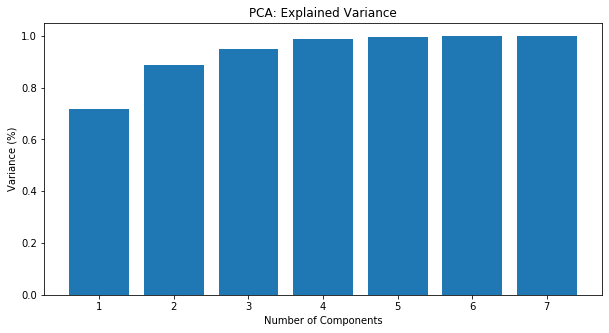

In [26]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

In [27]:
pca = PCA(n_components=optimalNumberOfClusters);
featureValues_std_pca = pca.fit_transform(featureValues_std);
featureValues_std_pca = pd.DataFrame(featureValues_std_pca);
featureValues_std_pca.index = featureValues.index
featureValues_std_pca.head()

,0,1,2
0,-0.839279,-0.817812,-0.338401
1,-0.839279,-0.817812,-0.338401
2,-0.839279,-0.817812,-0.338401
3,-0.839279,-0.817812,-0.338401
4,-0.839279,-0.817812,-0.338401


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [28]:
def estimateNumberOfClusters(featureValues, featureValues_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(featureValues_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [29]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [30]:
scores = []
numberOfCluster = []
maxNumberOfClusters = 10

for i in range(2, maxNumberOfClusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(featureValues_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimalNumberOfClusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

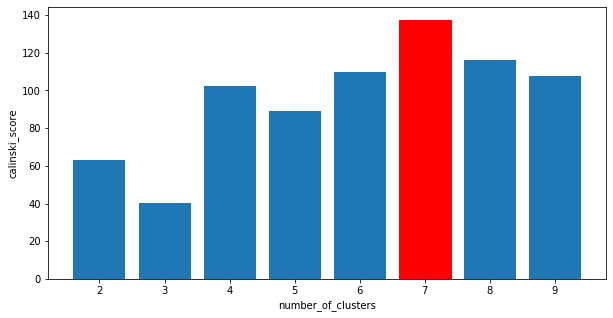

The optimal number of clusters is 7.


In [31]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimalNumberOfClusters))

# Ausreißer eliminieren

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange addresses rausgehauen werden.*

In [32]:

# def remove_outliers(featureValues, featureValues_std_pca, kmeans, threshold):
    
#     featureValues_std_pca_within_cluster_new = pd.DataFrame();
#     featureValues_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         featureValues_std_pca_within_cluster = featureValues_std_pca[kmeans_opt.labels_ == clusterNumber];
#         featureValues_within_cluster = featureValues[kmeans_opt.labels_ == clusterNumber];
            
#         distances = featureValues_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(featureValues_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         featureValues_std_pca_within_cluster_new = featureValues_std_pca_within_cluster_new.append(featureValues_std_pca_within_cluster[keep])
#         featureValues_within_cluster_new = featureValues_within_cluster_new.append(featureValues_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in featureValues_within_cluster[keep].iterrows()])
        
#     return featureValues_std_pca_within_cluster_new, featureValues_within_cluster_new, labels_new

In [33]:
# kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
# kmeans_opt.fit(featureValues_std_pca)

In [34]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(featureValues, featureValues_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [35]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [36]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [37]:
# featureValues, featureValues_std_pca, labels = remove_outliers(featureValues, featureValues_std_pca, kmeans_opt, optimalThreshold)
# featureValues_std_pca = pd.DataFrame(featureValues_std_pca)
# featureValues = pd.DataFrame(featureValues)

# Visualisierung: T-SNE

In [38]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# featureValues_std_pca_out_tsne = tsne.fit_transform(featureValues_std_pca_out)
# featureValues_std_pca_out_tsne = pd.DataFrame(featureValues_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# featureValues_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [39]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# featureValues_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# featureValues_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=featureValues_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Visualisierung PCA 3D Diagramm

In [40]:
# from mpl_toolkits.mplot3d import Axes3D
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(featureValues_out)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

In [41]:
# optimalNumberOfClusters = 2 # tmp
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

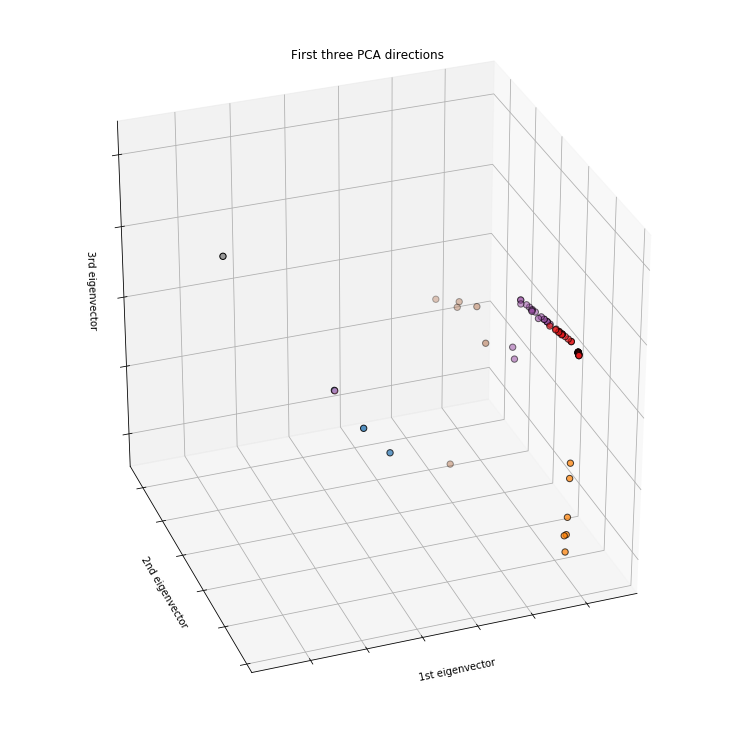

In [42]:
from mpl_toolkits.mplot3d import Axes3D;
# To getter a better understanding of interaction of the dimensions;
# plot the first three PCA dimensions;
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
X_reduced = PCA(n_components=3).fit_transform(featureValues_std);


ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_, cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

# Visualisierung: Vergleich der Ballungen

0      speculator_26
1      speculator_44
2      speculator_47
3      speculator_81
4      speculator_85
5      speculator_54
6       speculator_2
7      speculator_25
8      speculator_29
9      speculator_32
10     speculator_34
11     speculator_42
12     speculator_40
13     speculator_56
14     speculator_39
15     speculator_88
16     speculator_53
17     speculator_36
18     speculator_75
25     speculator_96
26     speculator_21
27     speculator_72
28     speculator_76
29     speculator_84
30      speculator_9
31     speculator_14
32     speculator_57
33     speculator_70
34     speculator_91
48     speculator_46
49    speculator_100
50     speculator_61
51     speculator_13
Name: address, dtype: object

64    exchange_3
65    exchange_5
66    exchange_4
Name: address, dtype: object

35    speculator_99
36    speculator_68
37    speculator_23
38     speculator_1
39    speculator_64
40     speculator_5
41    speculator_38
42    speculator_37
43    speculator_60
44    speculator_62
45    speculator_43
46    speculator_73
47    speculator_89
52    speculator_83
53    speculator_12
54    speculator_74
55    speculator_28
56    speculator_59
57     speculator_4
Name: address, dtype: object

19    speculator_58
20    speculator_80
21    speculator_45
22    speculator_67
23    speculator_90
24    speculator_78
Name: address, dtype: object

58     speculator_3
59    speculator_41
60    speculator_15
61    speculator_66
62    speculator_17
63    speculator_93
Name: address, dtype: object

67    exchange_1
Name: address, dtype: object

68    exchange_2
Name: address, dtype: object

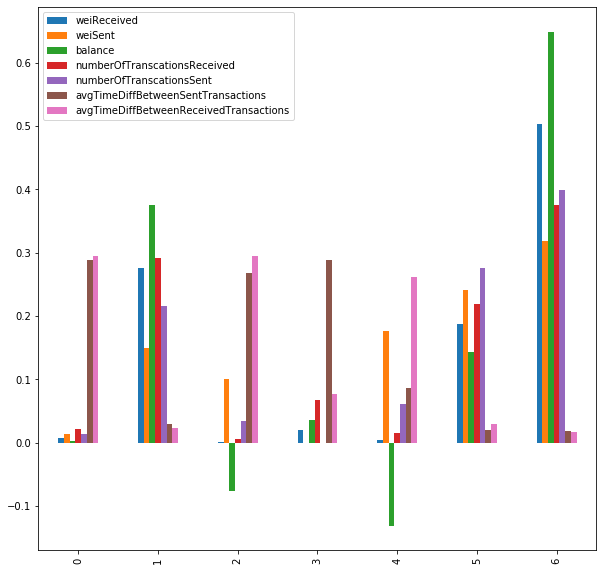

In [106]:
clusterMeans = []
cluster_size = {}

for i, center in enumerate(kmeans_opt.cluster_centers_):
#     print("Length of cluster {} is {}".format(i, len(featureValues[kmeans_opt.labels_==i])))
    within_cluster_featureValues = featureValues[kmeans_opt.labels_==i]
    cluster_size[i] = len(within_cluster_featureValues)
    display(addresses[kmeans_opt.labels_==i])
#     display(within_cluster_featureValues)
#     within_cluster_featureValues.columns = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent']
    clusterMeans.append(within_cluster_featureValues.mean())

x = pd.DataFrame(clusterMeans)
x.sum()
x = x / x.sum()
x.plot(kind="bar", figsize=(10,10))

In [94]:
cluster_size

{0: 33, 1: 3, 2: 19, 3: 6, 4: 6, 5: 1, 6: 1}

In [44]:
featureValues

,weiReceived,weiSent,balance,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,4.0,0.0,4.0,1,0,768.000000,840.000000
1,4.0,0.0,4.0,1,0,768.000000,840.000000
2,4.0,0.0,4.0,1,0,768.000000,840.000000
3,4.0,0.0,4.0,1,0,768.000000,840.000000
4,4.0,0.0,4.0,1,0,768.000000,840.000000
...,...,...,...,...,...,...,...
64,58.0,14.0,44.0,8,6,86.400000,68.571429
65,74.0,16.0,58.0,10,7,78.000000,62.666667
66,85.0,22.0,63.0,10,8,77.142857,61.333333
67,49.0,28.0,21.0,7,9,55.500000,86.000000


In [51]:
values1

array([0.01593693, 0.02206274, 0.01107548, 0.02981191, 0.02101024,
       0.29600482, 0.30362864])

In [61]:
# x.loc[:,"weiReceived"]# 
x

,weiReceived,weiSent,balance,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,0.007968,0.014094,0.003107,0.021843,0.013042,0.288036,0.295660
1,0.275663,0.149295,0.375948,0.292512,0.215189,0.030197,0.022594
2,0.001805,0.100185,-0.076269,0.006598,0.033977,0.267902,0.295660
3,0.019690,0.000000,0.035316,0.067905,0.000000,0.288036,0.077435
4,0.005081,0.176570,-0.131012,0.015670,0.061483,0.087011,0.261870
5,0.186739,0.241169,0.143544,0.219384,0.276672,0.020815,0.030270
6,0.503053,0.318687,0.649366,0.376087,0.399637,0.018002,0.016511


In [68]:
int("".join([str(len(values)), str(1), str(1)]))

711

In [111]:
values[5][0]

0.18673928040675042

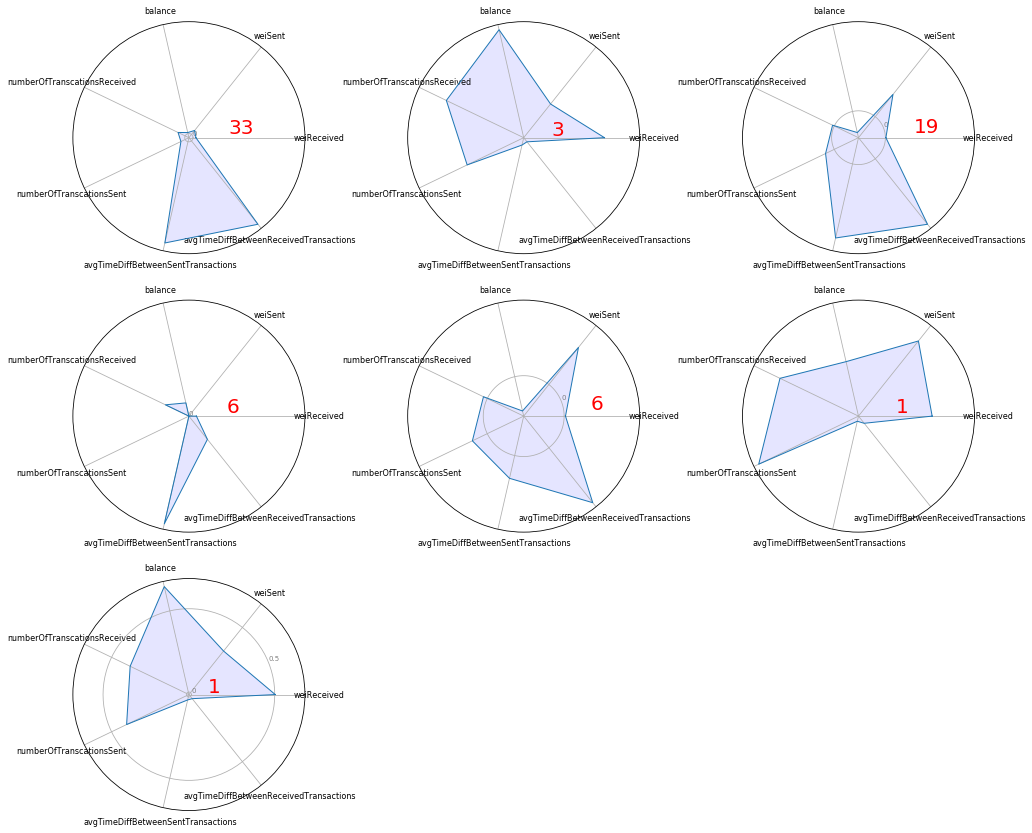

In [117]:
from math import pi

categories=list(x)
N = len(categories)

values = []

for i,v in enumerate(x): 
    tmp_values = x.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values.append(tmp_values)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(17,len(values)*5))

axes = []

for i, v in enumerate(values):
    position = int("".join([str(len(values)), str(3), str(i + 1)]))
    axes.append(plt.subplot(position, polar=True))

for i,a in enumerate(axes):
    plt.sca(a)
    plt.xticks(angles[:-1], categories, size=8)
    plt.yticks([0,0.5,1], ["0","0.5","1"], color="grey", size=7)
    a.plot(angles, values[i], linewidth=1, linestyle='solid')
    a.fill(angles, values[i], 'b', alpha=0.1)
    a.text(0.1,0.1, cluster_size[i], color = "red", size=20)


# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Temporary stuff

In [15]:
import collections as collections

Counter = collections.Counter

cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
num_doc= 0
positives = 0
negatives = 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []
for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    # calculating positives...
    positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

    # calculating TP...
    c = Counter(cluster_list[c])
    c_list.append(c)
    tp_temp = 0 
    for k,v in dict(c).items():
        if v>1:
            tp_temp += (v*(v-1))/2
    TP += tp_temp 

FP = positives - TP
negatives = ((num_doc*(num_doc-1))/2) - positives
# Add all the cluster together
sum = Counter()

for c in c_list:
    sum += c

# calculating FN...
for ct in c_list:
    fn_temp = 0 
    for k,v in dict(ct).items():
        fn_temp += v*(sum[k]-v)
    sum -= ct
    FN += fn_temp
TN = negatives -FN
print("num_doc is %d " % num_doc)
print("positives is %d " % positives)
print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)
print("TN is %d " % TN)

Precision = TP/(TP+FP)
print("Precision is %.2f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.2f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.2f " % F1)

num_doc is 17 
positives is 40 
TP is 20 
FP is 20 
FN is 24 
TN is 72 
Precision is 0.50 
Recall is 0.45 
F1 is 0.48 
